In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn import Module, Conv2d
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _quadruple
from torch.autograd import Variable
from torch.serialization import add_safe_globals

# Pretrained models
import torchvision.models as models
import torch.utils.model_zoo as model_zoo

# Numerical / scientific
import numpy as np
import math

# System / configuration
import os
from argparse import Namespace
from collections import OrderedDict

# Image processing
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import torchvision.transforms as T
import cv2

# Visualization
import matplotlib.pyplot as plt


In [3]:
#network/resnet.py

"""
This script is an adapted version of 
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py 
The goal is to keep ResNet* as only feature extractor, 
so the code can be used independent of the types of specific tasks,
i.e., classification or regression. 
"""



def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    PRETRAINED_URLs = {
        'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    }
    
    def __init__(self):
        super().__init__()
        
    def _build_model(self, block, layers):
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, early_feat=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        if early_feat:
            return x
        x = self.layer4(x)
        return x
    
    def forward_all(self, x, feat_list=[], early_feat=True):
        feat_list.append(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        feat_list.append(x)
        
        x = self.maxpool(x)
        x = self.layer1(x)
        feat_list.append(x)
        
        x = self.layer2(x)
        feat_list.append(x)
        
        x = self.layer3(x)
        feat_list.append(x)
        
        if not early_feat:
            x = self.layer4(x)
            feat_list.append(x)
    
    def load_pretrained_(self, ignore='fc'):
        print('Initialize ResNet using pretrained model from {}'.format(self.pretrained_url))
        state_dict = model_zoo.load_url(self.pretrained_url)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if ignore in k:
                continue
            new_state_dict[k] = v
        self.load_state_dict(new_state_dict)

    def change_stride(self, target='layer3'):
        layer = getattr(self, target)
        layer[0].conv1.stride = (1, 1)
        layer[0].conv2.stride = (1, 1)
        layer[0].downsample[0].stride = (1, 1) 

class ResNet34(ResNet):
    def __init__(self):
        super().__init__()
        self.pretrained_url = self.PRETRAINED_URLs['resnet34']
        self._build_model(BasicBlock, [3, 4, 6, 3])

class ResNet50(ResNet):
    def __init__(self):
        super().__init__()
        self.pretrained_url = self.PRETRAINED_URLs['resnet50']
        self._build_model(Bottleneck, [3, 4, 6, 3])
        
class ResNet101(ResNet):
    def __init__(self):
        super().__init__()
        self.pretrained_url = self.PRETRAINED_URLs['resnet101']
        self._build_model(Bottleneck, [3, 4, 23, 3])


In [4]:
#network/modules.py


L2Normalize = lambda feat, dim: feat / torch.pow(torch.sum(torch.pow(feat, 2), dim=dim) + 1e-6, 0.5).unsqueeze(dim)

def cal_conv_out_size(w, kernel_size, stride, padding):
    return (w - kernel_size + 2 * padding) // stride + 1

def maxpool4d(corr4d_hres, k_size=4):
    slices=[]
    for i in range(k_size):
        for j in range(k_size):
            for k in range(k_size):
                for l in range(k_size):
                    sl = corr4d_hres[:,:,i::k_size,j::k_size,k::k_size,l::k_size] # Support batches
                    slices.append(sl)
                    
    slices = torch.cat(tuple(slices),dim=1)  # B, ksize*4, h1, w1, h2, w2
    corr4d, max_idx = torch.max(slices,dim=1,keepdim=True)
    
    # i,j,k,l represent the *relative* coords of the max point in the box of size k_size*k_size*k_size*k_size    
    if torch.__version__ >= '1.6.0':
        max_l=torch.fmod(max_idx,k_size)
        max_k=torch.fmod(max_idx.sub(max_l).floor_divide(k_size),k_size)
        max_j=torch.fmod(max_idx.sub(max_l).floor_divide(k_size).sub(max_k).floor_divide(k_size),k_size)
        max_i=max_idx.sub(max_l).floor_divide(k_size).sub(max_k).floor_divide(k_size).sub(max_j).floor_divide(k_size)
    else:
        max_l=torch.fmod(max_idx,k_size)
        max_k=torch.fmod(max_idx.sub(max_l).div(k_size),k_size)
        max_j=torch.fmod(max_idx.sub(max_l).div(k_size).sub(max_k).div(k_size),k_size)
        max_i=max_idx.sub(max_l).div(k_size).sub(max_k).div(k_size).sub(max_j).div(k_size)
    return (corr4d,max_i,max_j,max_k,max_l)

class FeatCorrelation(torch.nn.Module):
    def __init__(self, shape='4D'):
        super().__init__()
        self.shape = shape
    
    def forward(self, feat1, feat2):        
        b, c, h1, w1 = feat1.size()
        b, c, h2, w2 = feat2.size()
        feat1 = feat1.view(b, c, h1*w1).transpose(1, 2) # size [b, h1*w1, c]
        feat2 = feat2.view(b, c, h2*w2)  # size [b, c, h2*w2]
        
        # Matrix multiplication
        correlation = torch.bmm(feat1, feat2)  # [b, h1*w1, h2*w2]
        if self.shape == '3D':
            correlation = correlation.view(b, h1, w1, h2*w2).permute(0, 3, 1, 2)  # [b, h2*w2, h1, w1]            
        elif self.shape == '4D':
            correlation = correlation.view(b, h1, w1, h2, w2).unsqueeze(1) # [b, 1, h1, w1, h2, w2]
        return correlation

    
class FeatRegressNet(nn.Module):
    def __init__(self, config, psize=16, out_dim=5):
        super().__init__()
        self.psize = psize
        self.conv_strs = config.conv_strs if 'conv_strs' in config else [2] * len(config.conv_kers)
        self.conv_dims = config.conv_dims
        self.conv_kers = config.conv_kers
        self.feat_comb = config.feat_comb  # Combine 2 feature maps before the conv or after the conv
        self.feat_dim = config.feat_dim if self.feat_comb == 'post' else 2 * config.feat_dim
        self.fc_in_dim = config.conv_dims[-1] * 2 if self.feat_comb == 'post' else config.conv_dims[-1]
        
        # Build layers    
        self.conv = self.make_conv_layers(self.feat_dim, self.conv_dims, self.conv_kers)
        self.fc = self.make_fc_layers(self.fc_in_dim, config.fc_dims, out_dim)        
        print(f'FeatRegressNet:  feat_comb:{self.feat_comb} ' \
              f'psize:{self.psize} out:{out_dim} ' \
              f'feat_dim:{self.feat_dim} conv_kers:{self.conv_kers} ' \
              f'conv_dims:{self.conv_dims} conv_str:{self.conv_strs} ' 
              )        
        
    def make_conv_layers(self, in_dim, conv_dims, conv_kers, bias=False):
        layers = []
        w = self.psize  # Initial spatial size        
        for out_dim, kernel_size, stride in zip(conv_dims, conv_kers, self.conv_strs):
            layers.append(nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=1, bias=bias))
            layers.append(nn.BatchNorm2d(out_dim))
            w = cal_conv_out_size(w, kernel_size, stride, 1)
            in_dim = out_dim
        layers.append(nn.ReLU())        
        # To make sure spatial dim goes to 1, one can also use AdaptiveMaxPool
        layers.append(nn.MaxPool2d(kernel_size=w))
        return nn.Sequential(*layers)
        
    def make_fc_layers(self, in_dim, fc_dims, fc_out_dim):
        layers = []
        for out_dim in fc_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.BatchNorm1d(out_dim)),
            layers.append(nn.ReLU())            
            in_dim = out_dim
            
        # Final layer
        layers.append(nn.Linear(in_dim, fc_out_dim))
        return nn.Sequential(*layers)
    
    def forward(self, feat1, feat2):
        # feat1, feat2: shape (N, D, 16, 16)       
        if self.feat_comb == 'pre':
            feat = torch.cat([feat1, feat2], dim=1)            
            feat = self.conv(feat)  # N, D, 1, 1
        else:
            feat1 = self.conv(feat1)
            feat2 = self.conv(feat2)            
            feat = torch.cat([feat1, feat2], dim=1)  # N, D, 1, 1
        feat = feat.view(-1, feat.shape[1])
        out = self.fc(feat)  # N, 5
        return out 
    
def init_optimizer(params, config):
    if config.opt == 'adam':
        optimizer = torch.optim.Adam(params, lr=config.lr_init, weight_decay=config.weight_decay)
        print('Setup  Adam optimizer(lr={},wd={})'.format(config.lr_init, config.weight_decay))

    elif config.opt == 'sgd':
        optimizer = torch.optim.SGD(params, momentum=0.9, lr=config.lr_init, weight_decay=config.weight_decay)
        print('Setup  SGD optimizer(lr={},wd={},mom=0.9)'.format(config.lr_init, config.weight_decay))

    if config.optimizer_dict:
        optimizer.load_state_dict(config.optimizer_dict)

    # Schedule learning rate decay  lr_decay = ['name', params] or None
    lr_scheduler = None
    if 'lr_decay' in config and config.lr_decay:
        if config.lr_decay[0] == 'step':
            decay_factor, decay_step = float(config.lr_decay[1]), int(config.lr_decay[2])
            last_epoch = config.start_epoch - 1
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                           step_size=decay_step, 
                                                           gamma=decay_factor, 
                                                           last_epoch=last_epoch)
            print(f'Setup StepLR Decay: decay_factor={decay_factor} '
                  f'step={decay_step} last_epoch={last_epoch}')

        elif config.lr_decay[0] == 'multistep':
            decay_factor = float(config.lr_decay[1])
            decay_steps = [int(v) for v in config.lr_decay[2::]]
            last_epoch = config.start_epoch - 1
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                                milestones=decay_steps,
                                                                gamma=decay_factor, 
                                                                last_epoch=last_epoch)
            print(f'Setup MultiStepLR Decay: decay_factor={decay_factor} '
                  f'steps={decay_steps} last_epoch={last_epoch}')

        if config.lr_scheduler_dict and lr_scheduler:
            lr_scheduler.load_state_dict(config.lr_scheduler_dict)
    return optimizer, lr_scheduler     
    
def xavier_init_func_(m):
    classname = m.__class__.__name__
    if classname.startswith('Conv'):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:  # Incase bias is turned off            
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:  # Incase bias is turned off            
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
    

In [5]:
#network/utils.py


def select_local_patch_feats(feats1, feats2, ibatch, imatches, 
                             feat_idx=[1, 2, 3, 4],
                             feats_downsample=[1, 2, 2, 2, 2],
                             psize=16, ptype='center'):
    dy, dx = torch.meshgrid(torch.arange(psize), torch.arange(psize))
    dx = dx.flatten().view(1, -1).to(imatches.device)
    dy = dy.flatten().view(1, -1).to(imatches.device)

    if ptype == 'center':
        shift = psize // 2
        dy -= shift
        dx -= shift    
    
    _, _, h1, w1 = feats1[0].shape
    _, _, h2, w2 = feats2[0].shape
    x1, y1, x2, y2 = imatches.permute(1, 0).long()

    # Ids for local patch
    get_x_pids = lambda x, w, ds: ((x.view(-1, 1) + dx).view(-1) // ds).long().clamp(min=0, max=w//ds-1)
    get_y_pids = lambda y, h, ds: ((y.view(-1, 1) + dy).view(-1) // ds).long().clamp(min=0, max=h//ds-1)

    # Collect features for local matches
    f1s, f2s = [], []
    for j, (fmap1, fmap2) in enumerate(zip(feats1, feats2)):
        if j not in feat_idx:
            continue 
        ds = np.prod(feats_downsample[0:j+1])
        f1s.append(fmap1[ibatch, :, get_y_pids(y1, h1, ds), get_x_pids(x1, w1, ds)])
        f2s.append(fmap2[ibatch, :, get_y_pids(y2, h2, ds), get_x_pids(x2, w2, ds)])
        
    f1s = torch.cat(f1s, dim=0) # D, N*16
    f2s = torch.cat(f2s, dim=0) # D, N*16
    return f1s, f2s, dx.squeeze(), dy.squeeze()

def filter_coarse(coarse_matches, match_scores, ncn_thres=0.0, mutual=True, ptmax=None):
    matches = []
    scores = []
    for imatches, iscores in  zip(coarse_matches, match_scores):
        _, ids, counts = np.unique(imatches.cpu().data.numpy(), axis=0, return_index=True, return_counts=True)
        if mutual:
            # Consider only if they are multual consistant 
            ids = ids[counts > 1]
            #print(len(imatches), len(ids))
            
        if len(ids) > 0:
            iscores = iscores[ids]
            imatches = imatches[ids]

        # NC score filtering
        ids = torch.nonzero(iscores.flatten() > ncn_thres, as_tuple=False).flatten()
        
        # Cut or fill upto ptmax for memory control
        if ptmax: 
            if len(ids) == 0:
                # insert a random match
                ids = torch.tensor([0, 0, 0, 0]).long()
            iids = np.arange(len(ids))
            np.random.shuffle(iids)
            iids = np.tile(iids, (ptmax // len(ids) + 1))[:ptmax]
            ids = ids[iids]
            
        if len(ids) > 0: 
            iscores = iscores[ids]
            imatches = imatches[ids]
            
        matches.append(imatches)
        scores.append(iscores)
        
    return matches, scores

def sym_epi_dist(matches, F, sqrt=True, eps=1e-8):
    # matches: Nx4
    # F: 3x3
    N = matches.shape[0]
    matches = matches.to(F)
    ones = torch.ones((N,1)).to(F)
    p1 = torch.cat([matches[:, 0:2] , ones], dim=1) 
    p2 = torch.cat([matches[:, 2:4] , ones], dim=1)

    # l2=F*x1, l1=F^T*x2
    l2 = F.matmul(p1.transpose(1, 0)) # 3,N
    l1 = F.transpose(1, 0).matmul(p2.transpose(1, 0))
    dd = (l2.transpose(1, 0) * p2).sum(dim=1)

    sqrt = False
    if sqrt:
        d = dd.abs() * (1.0 / (eps + l1[0, :] ** 2 + l1[1, :] ** 2).sqrt() + 1.0 / (eps + l2[0, :] ** 2 + l2[1, :] ** 2).sqrt())    
    else:
        d = dd ** 2 * (1.0 / (eps + l1[0, :] ** 2 + l1[1, :] ** 2) + 1.0 / (eps + l2[0, :] ** 2 + l2[1, :] ** 2))
    return d.float()

def sampson_dist(matches, F, eps=1e-8):
    # First-order approximation to reprojection error
    # matches: Nx4
    # F: 3x3
    N = matches.shape[0]
    matches = matches.to(F)
    ones = torch.ones((N,1)).to(F)
    p1 = torch.cat([matches[:, 0:2] , ones], dim=1) 
    p2 = torch.cat([matches[:, 2:4] , ones], dim=1)

    # l2=F*x1, l1=F^T*x2
    l2 = F.matmul(p1.transpose(1, 0)) # 3,N
    l1 = F.transpose(1, 0).matmul(p2.transpose(1, 0))
    dd = (l2.transpose(1, 0) * p2).sum(dim=1)
    d = dd ** 2 / (eps + l1[0, :] ** 2 + l1[1, :] ** 2 + l2[0, :] ** 2 + l2[1, :] ** 2)   
    return d.float()



In [6]:
#network/ncn/conv4d.py


def conv4d(data, filters, bias=None, permute_filters=True, use_half=False):
    b, c, h, w, d, t = data.size()

    data = data.permute(
        2, 0, 1, 3, 4, 5
    ).contiguous()  # permute to avoid making contiguous inside loop

    # Same permutation is done with filters, unless already provided with permutation
    if permute_filters:
        filters = filters.permute(
            2, 0, 1, 3, 4, 5
        ).contiguous()  # permute to avoid making contiguous inside loop

    c_out = filters.size(1)
    if use_half:
        output = Variable(
            torch.HalfTensor(h, b, c_out, w, d, t), requires_grad=data.requires_grad
        )
    else:
        output = Variable(
            torch.zeros(h, b, c_out, w, d, t), requires_grad=data.requires_grad
        )

    padding = filters.size(0) // 2
    if use_half:
        Z = Variable(torch.zeros(padding, b, c, w, d, t).half())
    else:
        Z = Variable(torch.zeros(padding, b, c, w, d, t))

    if data.is_cuda:
        Z = Z.cuda(data.get_device())
        output = output.cuda(data.get_device())

    data_padded = torch.cat((Z, data, Z), 0)

    for i in range(output.size(0)):  # loop on first feature dimension
        # convolve with center channel of filter (at position=padding)
        output[i, :, :, :, :, :] = F.conv3d(
            data_padded[i + padding, :, :, :, :, :],
            filters[padding, :, :, :, :, :],
            bias=bias,
            stride=1,
            padding=padding,
        )
        # convolve with upper/lower channels of filter (at postions [:padding] [padding+1:])
        for p in range(1, padding + 1):
            output[i, :, :, :, :, :] = output[i, :, :, :, :, :] + F.conv3d(
                data_padded[i + padding - p, :, :, :, :, :],
                filters[padding - p, :, :, :, :, :],
                bias=None,
                stride=1,
                padding=padding,
            )
            output[i, :, :, :, :, :] = output[i, :, :, :, :, :] + F.conv3d(
                data_padded[i + padding + p, :, :, :, :, :],
                filters[padding + p, :, :, :, :, :],
                bias=None,
                stride=1,
                padding=padding,
            )

    output = output.permute(1, 2, 0, 3, 4, 5).contiguous()
    return output


class Conv4d(_ConvNd):
    """Applies a 4D convolution over an input signal composed of several input
    planes.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        bias=True,
        pre_permuted_filters=True,
    ):
        # stride, dilation and groups !=1 functionality not tested
        stride = 1
        dilation = 1
        groups = 1
        # zero padding is added automatically in conv4d function to preserve tensor size
        padding = 0
        kernel_size = _quadruple(kernel_size)
        stride = _quadruple(stride)
        padding = _quadruple(padding)
        dilation = _quadruple(dilation)

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            False,
            _quadruple(0),
            groups,
            bias,
            padding_mode="zeros",
        )

        # weights will be sliced along one dimension during convolution loop
        # make the looping dimension to be the first one in the tensor,
        # so that we don't need to call contiguous() inside the loop
        self.pre_permuted_filters = pre_permuted_filters
        if self.pre_permuted_filters:
            self.weight.data = self.weight.data.permute(2, 0, 1, 3, 4, 5).contiguous()
        self.use_half = False

    def forward(self, input):
        return conv4d(
            input,
            self.weight,
            bias=self.bias,
            permute_filters=not self.pre_permuted_filters,
            use_half=self.use_half,
        )  # filters pre-permuted in constructor


In [7]:
#network/ncn/model.py


def Softmax1D(x,dim):
    x_k = torch.max(x,dim)[0].unsqueeze(dim)
    x -= x_k.expand_as(x)
    exp_x = torch.exp(x)
    return torch.div(exp_x,torch.sum(exp_x,dim).unsqueeze(dim).expand_as(x))

def featureL2Norm(feature):
    epsilon = 1e-6
    norm = torch.pow(torch.sum(torch.pow(feature,2),1)+epsilon,0.5).unsqueeze(1).expand_as(feature)
    feat_norm = torch.div(feature,norm)
    return feat_norm

class FeatureExtraction(torch.nn.Module):
    def __init__(self, train_fe=False, feature_extraction_cnn='resnet101', feature_extraction_model_file='', normalization=True, last_layer='', use_cuda=True):
        super(FeatureExtraction, self).__init__()
        self.normalization = normalization
        self.feature_extraction_cnn=feature_extraction_cnn
        if feature_extraction_cnn == 'vgg':
            self.model = models.vgg16(pretrained=True)
            # keep feature extraction network up to indicated layer
            vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
            if last_layer=='':
                last_layer = 'pool4'
            last_layer_idx = vgg_feature_layers.index(last_layer)
            self.model = nn.Sequential(*list(self.model.features.children())[:last_layer_idx+1])
        # for resnet below
        resnet_feature_layers = ['conv1','bn1','relu','maxpool','layer1','layer2','layer3','layer4']
        if feature_extraction_cnn=='resnet101':
            self.model = models.resnet101(pretrained=True)            
            if last_layer=='':
                last_layer = 'layer3'                            
            resnet_module_list = [getattr(self.model,l) for l in resnet_feature_layers]
            last_layer_idx = resnet_feature_layers.index(last_layer)
            self.model = nn.Sequential(*resnet_module_list[:last_layer_idx+1])

        if feature_extraction_cnn=='resnet101fpn':
            if feature_extraction_model_file!='':
                resnet = models.resnet101(pretrained=True) 
                # swap stride (2,2) and (1,1) in first layers (PyTorch ResNet is slightly different to caffe2 ResNet)
                # this is required for compatibility with caffe2 models
                resnet.layer2[0].conv1.stride=(2,2)
                resnet.layer2[0].conv2.stride=(1,1)
                resnet.layer3[0].conv1.stride=(2,2)
                resnet.layer3[0].conv2.stride=(1,1)
                resnet.layer4[0].conv1.stride=(2,2)
                resnet.layer4[0].conv2.stride=(1,1)
            else:
                resnet = models.resnet101(pretrained=True) 
            resnet_module_list = [getattr(resnet,l) for l in resnet_feature_layers]
            conv_body = nn.Sequential(*resnet_module_list)
            self.model = fpn_body(conv_body,
                                  resnet_feature_layers,
                                  fpn_layers=['layer1','layer2','layer3'],
                                  normalize=normalization,
                                  hypercols=True)
            if feature_extraction_model_file!='':
                self.model.load_pretrained_weights(feature_extraction_model_file)

        if feature_extraction_cnn == 'densenet201':
            self.model = models.densenet201(pretrained=True)
            # keep feature extraction network up to denseblock3
            # self.model = nn.Sequential(*list(self.model.features.children())[:-3])
            # keep feature extraction network up to transitionlayer2
            self.model = nn.Sequential(*list(self.model.features.children())[:-4])
        if train_fe==False:
            # freeze parameters
            for param in self.model.parameters():
                param.requires_grad = False
        # move to GPU
        if use_cuda:
            self.model = self.model.cuda()
        
    def forward(self, image_batch):
        features = self.model(image_batch)
        if self.normalization and not self.feature_extraction_cnn=='resnet101fpn':
            features = featureL2Norm(features)
        return features
    
class FeatureCorrelation(torch.nn.Module):
    def __init__(self,shape='3D',normalization=True):
        super(FeatureCorrelation, self).__init__()
        self.normalization = normalization
        self.shape=shape
        self.ReLU = nn.ReLU()
    
    def forward(self, feature_A, feature_B):        
        if self.shape=='3D':
            b,c,h,w = feature_A.size()
            # reshape features for matrix multiplication
            feature_A = feature_A.transpose(2,3).contiguous().view(b,c,h*w)
            feature_B = feature_B.view(b,c,h*w).transpose(1,2)
            # perform matrix mult.
            feature_mul = torch.bmm(feature_B,feature_A)
            # indexed [batch,idx_A=row_A+h*col_A,row_B,col_B]
            correlation_tensor = feature_mul.view(b,h,w,h*w).transpose(2,3).transpose(1,2)
        elif self.shape=='4D':
            b,c,hA,wA = feature_A.size()
            b,c,hB,wB = feature_B.size()
            # reshape features for matrix multiplication
            feature_A = feature_A.view(b,c,hA*wA).transpose(1,2) # size [b,c,h*w]
            feature_B = feature_B.view(b,c,hB*wB) # size [b,c,h*w]
            # perform matrix mult.
            feature_mul = torch.bmm(feature_A,feature_B)
            # indexed [batch,row_A,col_A,row_B,col_B]
            correlation_tensor = feature_mul.view(b,hA,wA,hB,wB).unsqueeze(1)
        
        if self.normalization:
            correlation_tensor = featureL2Norm(self.ReLU(correlation_tensor))
            
        return correlation_tensor

class NeighConsensus(torch.nn.Module):
    def __init__(self, use_cuda=True, kernel_sizes=[3,3,3], channels=[10,10,1], symmetric_mode=True):
        super(NeighConsensus, self).__init__()
        self.symmetric_mode = symmetric_mode
        self.kernel_sizes = kernel_sizes
        self.channels = channels
        num_layers = len(kernel_sizes)
        nn_modules = list()
        for i in range(num_layers):
            if i==0:
                ch_in = 1
            else:
                ch_in = channels[i-1]
            ch_out = channels[i]
            k_size = kernel_sizes[i]
            nn_modules.append(Conv4d(in_channels=ch_in,out_channels=ch_out,kernel_size=k_size,bias=True))
            nn_modules.append(nn.ReLU(inplace=True))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv = nn.Sequential(*nn_modules).to(device)


    def forward(self, x):
        if self.symmetric_mode:
            # apply network on the input and its "transpose" (swapping A-B to B-A ordering of the correlation tensor),
            # this second result is "transposed back" to the A-B ordering to match the first result and be able to add together
            x = self.conv(x)+self.conv(x.permute(0,1,4,5,2,3)).permute(0,1,4,5,2,3)
            # because of the ReLU layers in between linear layers, 
            # this operation is different than convolving a single time with the filters+filters^T
            # and therefore it makes sense to do this.
        else:
            x = self.conv(x)
        return x

def MutualMatching(corr4d):
    # mutual matching
    batch_size,ch,fs1,fs2,fs3,fs4 = corr4d.size()

    corr4d_B=corr4d.view(batch_size,fs1*fs2,fs3,fs4) # [batch_idx,k_A,i_B,j_B]
    corr4d_A=corr4d.view(batch_size,fs1,fs2,fs3*fs4)

    # get max
    corr4d_B_max,_=torch.max(corr4d_B,dim=1,keepdim=True)
    corr4d_A_max,_=torch.max(corr4d_A,dim=3,keepdim=True)

    eps = 1e-5
    corr4d_B=corr4d_B/(corr4d_B_max+eps)
    corr4d_A=corr4d_A/(corr4d_A_max+eps)

    corr4d_B=corr4d_B.view(batch_size,1,fs1,fs2,fs3,fs4)
    corr4d_A=corr4d_A.view(batch_size,1,fs1,fs2,fs3,fs4)

    corr4d=corr4d*(corr4d_A*corr4d_B) # parenthesis are important for symmetric output 
    return corr4d

def MutualNorm(corr4d):
    # mutual matching
    batch_size,ch,fs1,fs2,fs3,fs4 = corr4d.size()

    corr4d_B=corr4d.view(batch_size,fs1*fs2,fs3,fs4) # [batch_idx,k_A,i_B,j_B]
    corr4d_A=corr4d.view(batch_size,fs1,fs2,fs3*fs4)

    # get max
    corr4d_B_max,_=torch.max(corr4d_B,dim=1,keepdim=True)
    corr4d_A_max,_=torch.max(corr4d_A,dim=3,keepdim=True)

    eps = 1e-5
    corr4d_B=corr4d_B/(corr4d_B_max+eps)
    corr4d_A=corr4d_A/(corr4d_A_max+eps)

    corr4d_B=corr4d_B.view(batch_size,1,fs1,fs2,fs3,fs4)
    corr4d_A=corr4d_A.view(batch_size,1,fs1,fs2,fs3,fs4)
    return (corr4d_A*corr4d_B)

def maxpool4d(corr4d_hres,k_size=4):
    slices=[]
    for i in range(k_size):
        for j in range(k_size):
            for k in range(k_size):
                for l in range(k_size):
                    sl = corr4d_hres[:,0,i::k_size,j::k_size,k::k_size,l::k_size].unsqueeze(0)
                    slices.append(sl)

    slices=torch.cat(tuple(slices),dim=1)
    corr4d,max_idx=torch.max(slices,dim=1,keepdim=True)
    max_l=torch.fmod(max_idx,k_size)
    max_k=torch.fmod(max_idx.sub(max_l).div(k_size),k_size)
    max_j=torch.fmod(max_idx.sub(max_l).div(k_size).sub(max_k).div(k_size),k_size)
    max_i=max_idx.sub(max_l).div(k_size).sub(max_k).div(k_size).sub(max_j).div(k_size)
    # i,j,k,l represent the *relative* coords of the max point in the box of size k_size*k_size*k_size*k_size
    return (corr4d,max_i,max_j,max_k,max_l)

class ImMatchNet(nn.Module):
    def __init__(self, 
                 feature_extraction_cnn='resnet101', 
                 feature_extraction_last_layer='',
                 feature_extraction_model_file=None,
                 return_correlation=False,  
                 ncons_kernel_sizes=[3,3,3],
                 ncons_channels=[10,10,1],
                 normalize_features=True,
                 train_fe=False,
                 use_cuda=True,
                 relocalization_k_size=0,
                 half_precision=False,
                 checkpoint=None,
                 ):
        
        super(ImMatchNet, self).__init__()
        # Load checkpoint
        if checkpoint is not None and checkpoint is not '':
            print('Loading checkpoint...')
            checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)
            checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
            # override relevant parameters
            print('Using checkpoint parameters: ')
            ncons_channels=checkpoint['args'].ncons_channels
            print('  ncons_channels: '+str(ncons_channels))
            ncons_kernel_sizes=checkpoint['args'].ncons_kernel_sizes
            print('  ncons_kernel_sizes: '+str(ncons_kernel_sizes))            

        self.use_cuda = use_cuda
        self.normalize_features = normalize_features
        self.return_correlation = return_correlation
        self.relocalization_k_size = relocalization_k_size
        self.half_precision = half_precision
        
        self.FeatureExtraction = FeatureExtraction(train_fe=train_fe,
                                                   feature_extraction_cnn=feature_extraction_cnn,
                                                   feature_extraction_model_file=feature_extraction_model_file,
                                                   last_layer=feature_extraction_last_layer,
                                                   normalization=normalize_features,
                                                   use_cuda=self.use_cuda)
        
        self.FeatureCorrelation = FeatureCorrelation(shape='4D',normalization=False)

        self.NeighConsensus = NeighConsensus(use_cuda=self.use_cuda,
                                             kernel_sizes=ncons_kernel_sizes,
                                             channels=ncons_channels)

        # Load weights
        if checkpoint is not None and checkpoint is not '':
            print('Copying weights...')
            for name, param in self.FeatureExtraction.state_dict().items():
                if 'num_batches_tracked' not in name:
                    self.FeatureExtraction.state_dict()[name].copy_(checkpoint['state_dict']['FeatureExtraction.' + name])    
            for name, param in self.NeighConsensus.state_dict().items():
                self.NeighConsensus.state_dict()[name].copy_(checkpoint['state_dict']['NeighConsensus.' + name])
            print('Done!')
        
        self.FeatureExtraction.eval()

        if self.half_precision:
            for p in self.NeighConsensus.parameters():
                p.data=p.data.half()
            for l in self.NeighConsensus.conv:
                if isinstance(l,Conv4d):
                    l.use_half=True
                    
    # used only for foward pass at eval and for training with strong supervision
    def forward(self, tnf_batch): 
        # feature extraction
        feature_A = self.FeatureExtraction(tnf_batch['source_image'])
        feature_B = self.FeatureExtraction(tnf_batch['target_image'])
        if self.half_precision:
            feature_A=feature_A.half()
            feature_B=feature_B.half()
            
        # feature correlation
        corr4d = self.FeatureCorrelation(feature_A,feature_B)

        # do 4d maxpooling for relocalization
        if self.relocalization_k_size>1:
            corr4d,max_i,max_j,max_k,max_l=maxpool4d(corr4d,k_size=self.relocalization_k_size)

        # run match processing model
        corr4d = MutualMatching(corr4d)
        corr4d = self.NeighConsensus(corr4d)
        corr4d = MutualMatching(corr4d)
        
        if self.relocalization_k_size>1:
            delta4d=(max_i,max_j,max_k,max_l)
            return (corr4d,delta4d)
        else:
            return corr4d
 
    def forward_feat(self, featA, featB, normalize=True): 
        # feature normalization
        if normalize:
            feature_A = featureL2Norm(featA)
            feature_B = featureL2Norm(featB)
        else:
            feature_A = featA
            feature_B = featB
        if self.half_precision:
            feature_A=feature_A.half()
            feature_B=feature_B.half()

        # feature correlation
        corr4d = self.FeatureCorrelation(feature_A,feature_B)
        # do 4d maxpooling for relocalization
        if self.relocalization_k_size>1:
            corr4d,max_i,max_j,max_k,max_l=maxpool4d(corr4d,k_size=self.relocalization_k_size)
        corr4d = MutualMatching(corr4d)
        corr4d = self.NeighConsensus(corr4d)
        corr4d = MutualMatching(corr4d)
        if self.relocalization_k_size>1:
            delta4d=(max_i,max_j,max_k,max_l)
            return (corr4d,delta4d)
        else:
            return corr4d


<>:228: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:259: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:228: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:259: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_19/3988810092.py:228: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if checkpoint is not None and checkpoint is not '':
/tmp/ipykernel_19/3988810092.py:259: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if checkpoint is not None and checkpoint is not '':


In [8]:
#ncn/extract_matches.py

import torch
import torch.nn
from torch.autograd import Variable
import numpy as np

def corr_to_matches(corr4d, delta4d=None, ksize=1, do_softmax=True, scale='positive', 
                    invert_matching_direction=False, return_indices=True):
    to_cuda = lambda x: x.to(corr4d.device) if corr4d.is_cuda else x        
    batch_size,ch,fs1,fs2,fs3,fs4 = corr4d.size()  # b, c, h, w, h, w
    if scale=='centered':
        XA,YA=np.meshgrid(np.linspace(-1,1,fs2*ksize),np.linspace(-1,1,fs1*ksize))
        XB,YB=np.meshgrid(np.linspace(-1,1,fs4*ksize),np.linspace(-1,1,fs3*ksize))
    elif scale=='positive':
        # Upsampled resolution linear space
        XA,YA=np.meshgrid(np.linspace(0,1,fs2*ksize),np.linspace(0,1,fs1*ksize))
        XB,YB=np.meshgrid(np.linspace(0,1,fs4*ksize),np.linspace(0,1,fs3*ksize))
    # Index meshgrid for current resolution
    JA,IA=np.meshgrid(range(fs2),range(fs1)) 
    JB,IB=np.meshgrid(range(fs4),range(fs3))
    
    XA,YA=Variable(to_cuda(torch.FloatTensor(XA))),Variable(to_cuda(torch.FloatTensor(YA)))
    XB,YB=Variable(to_cuda(torch.FloatTensor(XB))),Variable(to_cuda(torch.FloatTensor(YB)))

    JA,IA=Variable(to_cuda(torch.LongTensor(JA).view(1,-1))),Variable(to_cuda(torch.LongTensor(IA).view(1,-1)))
    JB,IB=Variable(to_cuda(torch.LongTensor(JB).view(1,-1))),Variable(to_cuda(torch.LongTensor(IB).view(1,-1)))
    
    if invert_matching_direction:
        nc_A_Bvec=corr4d.view(batch_size,fs1,fs2,fs3*fs4)

        if do_softmax:
            nc_A_Bvec=torch.nn.functional.softmax(nc_A_Bvec,dim=3)

        # Max and argmax
        match_A_vals,idx_A_Bvec=torch.max(nc_A_Bvec,dim=3)
        score=match_A_vals.view(batch_size,-1)
        
        # Pick the indices for the best score
        iB=IB.view(-1)[idx_A_Bvec.view(-1)].view(batch_size,-1).contiguous()  # b, h1*w1
        jB=JB.view(-1)[idx_A_Bvec.view(-1)].view(batch_size,-1).contiguous()
        iA=IA.expand_as(iB).contiguous()
        jA=JA.expand_as(jB).contiguous()
        
    else:    
        nc_B_Avec=corr4d.view(batch_size,fs1*fs2,fs3,fs4) # [batch_idx,k_A,i_B,j_B]
        if do_softmax:
            nc_B_Avec=torch.nn.functional.softmax(nc_B_Avec,dim=1)

        match_B_vals,idx_B_Avec=torch.max(nc_B_Avec,dim=1)
        score=match_B_vals.view(batch_size,-1)
        
        iA=IA.view(-1)[idx_B_Avec.view(-1)].view(batch_size,-1).contiguous() # b, h2*w2
        jA=JA.view(-1)[idx_B_Avec.view(-1)].view(batch_size,-1).contiguous() 
        iB=IB.expand_as(iA).contiguous()
        jB=JB.expand_as(jA).contiguous()
    
    if delta4d is not None: # relocalization, it is also the case ksize > 1
        # The shift within the pooling window reference to (0,0,0,0)
        delta_iA, delta_jA, delta_iB, delta_jB = delta4d  # b, 1, h1, w1, h2, w2 
        
        """ Original implementation
        # Reorder the indices according 
        diA = delta_iA.squeeze(0).squeeze(0)[iA.view(-1), jA.view(-1), iB.view(-1), jB.view(-1)] 
        djA = delta_jA.squeeze(0).squeeze(0)[iA.view(-1), jA.view(-1), iB.view(-1), jB.view(-1)]        
        diB = delta_iB.squeeze(0).squeeze(0)[iA.view(-1), jA.view(-1), iB.view(-1), jB.view(-1)]
        djB = delta_jB.squeeze(0).squeeze(0)[iA.view(-1), jA.view(-1), iB.view(-1), jB.view(-1)]

        # *ksize place the pixel to the 1st location in upsampled 4D-Volumn
        iA = iA * ksize + diA.expand_as(iA)
        jA = jA * ksize + djA.expand_as(jA)
        iB = iB * ksize + diB.expand_as(iB)
        jB = jB * ksize + djB.expand_as(jB)
        """
        
        # Support batches
        for ibx in range(batch_size):
            diA = delta_iA[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]  # h*w
            djA = delta_jA[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]
            diB = delta_iB[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]
            djB = delta_jB[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]
            
            iA[ibx] = iA[ibx] * ksize + diA
            jA[ibx] = jA[ibx] * ksize + djA
            iB[ibx] = iB[ibx] * ksize + diB
            jB[ibx] = jB[ibx] * ksize + djB

    xA = XA[iA.view(-1), jA.view(-1)].view(batch_size, -1)
    yA = YA[iA.view(-1), jA.view(-1)].view(batch_size, -1)
    xB = XB[iB.view(-1), jB.view(-1)].view(batch_size, -1)
    yB = YB[iB.view(-1), jB.view(-1)].view(batch_size, -1)
        
    if return_indices:
        return (jA,iA,jB,iB,score)
    else:
        return (xA,yA,xB,yB,score)    
    
def corr_to_matches_topk(corr4d, delta4d=None, topk=1, ksize=1, do_softmax=True,                     
                         invert_matching_direction=False):

    device = corr4d.device
    batch_size, ch, fs1, fs2, fs3, fs4 = corr4d.size()  # b, c, h, w, h, w

    # Index meshgrid for current resolution
    JA, IA = np.meshgrid(range(fs2), range(fs1)) 
    JB, IB = np.meshgrid(range(fs4), range(fs3))    
    JA, IA = torch.LongTensor(JA).view(1,-1).to(device), torch.LongTensor(IA).view(1,-1).to(device)
    JB, IB = torch.LongTensor(JB).view(1,-1).to(device), torch.LongTensor(IB).view(1,-1).to(device)

    if invert_matching_direction:
        nc_A_Bvec = corr4d.view(batch_size, fs1, fs2, fs3 * fs4)

        if do_softmax:
            nc_A_Bvec = torch.nn.functional.softmax(nc_A_Bvec, dim=3)

        # Max and argmax
        match_A_vals, idx_A_Bvec = torch.topk(nc_A_Bvec, topk, dim=3, largest=True, sorted=True)    
        score = match_A_vals.view(batch_size, -1)

        # Pick the indices for the best score
        iB = IB.view(-1)[idx_A_Bvec.view(-1)].view(batch_size, -1, topk).contiguous()
        jB = JB.view(-1)[idx_A_Bvec.view(-1)].view(batch_size, -1, topk).contiguous()
        iA = IA.unsqueeze(-1).expand_as(iB).contiguous()
        jA = JA.unsqueeze(-1).expand_as(jB).contiguous()

    else:    
        nc_B_Avec = corr4d.view(batch_size, fs1 * fs2, fs3, fs4) # [batch_idx,k_A,i_B,j_B]
        if do_softmax:
            nc_B_Avec = torch.nn.functional.softmax(nc_B_Avec, dim=1)

        match_B_vals, idx_B_Avec = torch.topk(nc_B_Avec, topk, dim=1, largest=True, sorted=True)
        score = match_B_vals.view(batch_size, -1)

        iA = IA.view(-1)[idx_B_Avec.view(-1)].view(batch_size, topk, -1).contiguous()
        jA = JA.view(-1)[idx_B_Avec.view(-1)].view(batch_size, topk, -1).contiguous() 
        iB = IB.unsqueeze(1).expand_as(iA).contiguous() 
        jB = JB.unsqueeze(1).expand_as(jA).contiguous()
        
    iA = iA.view(batch_size, -1)
    jA = jA.view(batch_size, -1)
    iB = iB.view(batch_size, -1)
    jB = jB.view(batch_size, -1)   

    if delta4d is not None: # relocalization, it is also the case ksize > 1
        # The shift within the pooling window reference to (0,0,0,0)
        delta_iA, delta_jA, delta_iB, delta_jB = delta4d

        # Support batches
        for ibx in range(batch_size):
            diA = delta_iA[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]  # h*w
            djA = delta_jA[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]
            diB = delta_iB[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]
            djB = delta_jB[ibx][0][iA[ibx], jA[ibx], iB[ibx], jB[ibx]]
            
            iA[ibx] = iA[ibx] * ksize + diA
            jA[ibx] = jA[ibx] * ksize + djA
            iB[ibx] = iB[ibx] * ksize + diB
            jB[ibx] = jB[ibx] * ksize + djB

    return (jA, iA, jB, iB, score)


In [9]:
#Patch2Pix.py (one line changed to be runned on a single notebook)



class Patch2Pix(nn.Module):    
    def __init__(self, config):
        super().__init__()
        self.device = config.device
        self.backbone = config.backbone
        self.change_stride = config.change_stride        
        self.upsample = 16
        self.feats_downsample = [1, 2, 2, 2, 2]
        feat_dims = [3, 64, 64, 128, 256]  # Resnet34 block feature out dims 
        
        # Initialize necessary network components
        self.extract = globals()[self.backbone]() #resnet istaken from globals here since everything is in the same notebook
        if self.change_stride:
            self.extract.change_stride(target='layer3')
            self.upsample //= 2            
            self.feats_downsample[-1] = 1        
        print(f'Initialize Patch2Pix: backbone={self.backbone} '
              f'cstride={self.change_stride} upsample={self.upsample}')
        
        self.combine = FeatCorrelation(shape='4D')
        self.ncn = NeighConsensus(kernel_sizes=[3, 3], channels=[16, 1])
        
        # Initialize regressor
        self.regressor_config = config.regressor_config
        if not self.regressor_config:
            # If no regressor defined, model only computes coarse matches
            self.regress_mid = None
            self.regress_fine = None
        else:
            print(f'Init regressor {self.regressor_config}')
            self.regr_batch = config.regr_batch
            self.feat_idx = config.feat_idx            
            feat_dim = 0  # Regressor's input feature dim
            for idx in self.feat_idx:
                feat_dim += feat_dims[idx]           
            self.regressor_config.feat_dim = feat_dim            
            self.ptype = ['center', 'center']
            self.psize = config.regressor_config.psize            
            self.pshift = config.regressor_config.pshift
            self.panc = config.regressor_config.panc
            self.shared = config.regressor_config.shared
            self.regress_mid = FeatRegressNet(self.regressor_config, psize=self.psize[0])
            if self.shared:
                self.regress_fine = self.regress_mid
                self.psize[1] = self.psize[0]
            else:
                self.regress_fine = FeatRegressNet(self.regressor_config, psize=self.psize[1])
            
        self.to(self.device)
        self.init_weights_(weights_dict=config.weights_dict, pretrained=True)        
           
        if config.training:
            self.freeze_feat = config.freeze_feat
            # Freeze (part of) the backbone
            print('Freezing feature extractor params upto layer {}'.format(self.freeze_feat))
            for i, param in enumerate(self.extract.parameters()):         
                # Resnet34 layer3=[48:87] blocks:
                # 0=[48:57] 1=[57:63] 2=[63:69]
                # 3=[69:75] 4=[75:81] 5=[81:87] 
                if i < self.freeze_feat:
                    param.requires_grad = False

                # Always freeze resnet layer4, since never used
                if i >= 87:
                    param.requires_grad = False        
            
            config.optim_config.start_epoch = config.start_epoch
            self.set_optimizer_(config.optim_config)
    
    def set_optimizer_(self, optim_config): 
        params = []
        if self.regress_mid:
            params += list(self.regress_mid.parameters()) 
        if self.regress_fine and not self.shared:
            params += list(self.regress_fine.parameters())         
        params += list(self.ncn.parameters())
        if self.freeze_feat < 87:
            params += list(self.extract.parameters())[self.freeze_feat:87]
        self.optimizer, self.lr_scheduler = init_optimizer(params, optim_config)
        print('Init optimizer, items: {}'.format(len(params)))

    def optim_step_(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()            
                
    def init_weights_(self, weights_dict=None, pretrained=True):
        print('Xavier initialize all model parameters')
        self.apply(xavier_init_func_)
        if pretrained:
            self.extract.load_pretrained_()
        if weights_dict:
            if len(weights_dict.items()) == len(self.state_dict()):
                print('Reload all model parameters from weights dict')
                self.load_state_dict(weights_dict)
            else:
                print('Reload part of model parameters from weights dict')
                self.load_state_dict(weights_dict, strict=False)       
                
    def load_batch_(self, batch, dtype='pair'):
        im_src = batch['src_im'].to(self.device)
        im_pos = batch['pos_im'].to(self.device)
        Fs = batch['F'].to(self.device)            
        if dtype == 'triplet':
            im_neg = batch['neg_im'].to(self.device)
            return im_src, im_pos, im_neg, Fs
        return im_src, im_pos, Fs    

    def forward_coarse_match(self, feat1, feat2, ksize=1):
        # Feature normalization
        feat1 = L2Normalize(feat1, dim=1)
        feat2 = L2Normalize(feat2, dim=1)
        
        # Feature correlation
        corr4d = self.combine(feat1, feat2)
        
        # Do 4d maxpooling for relocalization
        delta4d = None
        if ksize > 1:
            corr4d, max_i, max_j, max_k, max_l = maxpool4d(corr4d, k_size=ksize)
            delta4d = (max_i,max_j,max_k,max_l)
        corr4d = MutualMatching(corr4d)            
        corr4d = self.ncn(corr4d)
        corr4d = MutualMatching(corr4d)        
        return corr4d, delta4d

    def parse_regressor_out(self, out, psize, ptype, imatches, max_val):
        w1, h1, w2, h2 = max_val
        offset = out[:, :4] # N, 4
        offset = psize * torch.tanh(nn.functional.relu(offset))        
        if ptype == 'center':
            shift = psize // 2
            offset -= shift
        fmatches = imatches.float() + offset
        io_probs = out[:, 4]
        io_probs = torch.sigmoid(io_probs)
        
        # Prevent out of range
        x1 = fmatches[:, 0].clamp(min=0, max=w1)
        y1 = fmatches[:, 1].clamp(min=0, max=h1)
        x2 = fmatches[:, 2].clamp(min=0, max=w2)
        y2 = fmatches[:, 3].clamp(min=0, max=h2)
        fmatches = torch.stack([x1, y1, x2, y2], dim=-1)
        return fmatches, io_probs

    def forward_fine_match_mini_batch(self, feats1, feats2, ibatch, imatches,
                                      psize, ptype, regressor):
        # ibatch: to index the feature map
        # imatches: input coarse matches, N, 4
        N = imatches.shape[0]
        _, _, h1, w1 = feats1[0].shape
        _, _, h2, w2 = feats2[0].shape
        max_val = [w1, h1, w2, h2]
        
        f1s, f2s, _, _ = select_local_patch_feats(feats1, feats2,
                                                  ibatch, imatches,
                                                  feat_idx=self.feat_idx,
                                                  feats_downsample=self.feats_downsample,
                                                  psize=psize,
                                                  ptype=ptype)    
        # Feature normalization
        f1s = L2Normalize(f1s, dim=0)  # D, N*psize*psize
        f2s = L2Normalize(f2s, dim=0)  # D, N*psize*psize

        # Reshaping: -> (D, N, psize, psize) -> (N, D, psize, psize)
        f1s = f1s.view(-1, N, psize, psize).permute(1, 0, 2, 3)
        f2s = f2s.view(-1, N, psize, psize).permute(1, 0, 2, 3)   

     
        # From im1 to im2       
        out = regressor(f1s, f2s)  # N, 5
        fmatches, io_probs = self.parse_regressor_out(out, psize, ptype, imatches, max_val)
        return fmatches, io_probs
    
    def forward_fine_match(self, feats1, feats2, coarse_matches, 
                           psize, ptype, regressor):
        batch_size = self.regr_batch
        masks = []
        fine_matches = []
        for ibatch, imatches in enumerate(coarse_matches):
            # Use mini-batch if too many matches
            N = imatches.shape[0]
            if N > batch_size:                
                batch_inds = [batch_size*i for i in range(N // batch_size + 1)]
                if batch_inds[-1] < N:
                    if N -  batch_inds[-1] == 1:
                        # Special case, slicing leads to 1-dim missing
                        batch_inds[-1] = N
                    else:
                        batch_inds += [N]
                fmatches = []
                io_probs = []
                for bi, (ist, ied) in enumerate(zip(batch_inds[0:-1], batch_inds[1::])):
                    mini_results = self.forward_fine_match_mini_batch(feats1, feats2, 
                                                                      ibatch, imatches[ist:ied],
                                                                      psize, ptype, regressor)
                    fmatches.append(mini_results[0])
                    io_probs.append(mini_results[1])
                fmatches = torch.cat(fmatches, dim=0).squeeze()
                io_probs = torch.cat(io_probs, dim=0).squeeze()
            else:
                fmatches, io_probs = self.forward_fine_match_mini_batch(feats1, feats2, 
                                                                        ibatch, imatches,
                                                                        psize, ptype, regressor)
            fine_matches.append(fmatches)
            masks.append(io_probs)                        
        return fine_matches, masks

    def forward(self, im1, im2, ksize=1, return_feats=False):
        if return_feats:
            feat1s=[]
            feat2s=[]
            self.extract.forward_all(im1, feat1s, early_feat=True)        
            self.extract.forward_all(im2, feat2s, early_feat=True)
            feat1 = feat1s[-1]
            feat2 = feat2s[-1]
        else:
            feat1 = self.extract(im1, early_feat=True)        
            feat2 = self.extract(im2, early_feat=True)     # Shared weights
        
        corr4d, delta4d = self.forward_coarse_match(feat1, feat2, ksize=ksize)
        
        if return_feats:
            return corr4d, delta4d, feat1s, feat2s                            
        else:
            return corr4d, delta4d
        
        
    def predict_coarse(self, im1, im2, ksize=2, ncn_thres=0.0,
                       mutual=False, center=True):
        corr4d, delta4d = self.forward(im1, im2, ksize)
        coarse_matches, match_scores = self.cal_coarse_matches(corr4d, delta4d, ksize=ksize, 
                                                               upsample=self.upsample, center=center)
        
        # Filter coarse matches
        coarse_matches, match_scores = filter_coarse(coarse_matches, match_scores, ncn_thres, mutual)
        return coarse_matches, match_scores
    
    def predict_fine(self, im1, im2, ksize=2, ncn_thres=0.0,
                     mutual=True, return_all=False):
        corr4d, delta4d, feats1, feats2 = self.forward(im1, im2, ksize=ksize, return_feats=True)
        coarse_matches, match_scores = self.cal_coarse_matches(corr4d, delta4d, ksize=ksize,
                                                               upsample=self.upsample, center=True)
        # Filter coarse matches
        coarse_matches, match_scores = filter_coarse(coarse_matches, match_scores, ncn_thres, mutual)
        
        # Locate initial anchors
        coarse_matches = self.shift_to_anchors(coarse_matches)
        
        # Mid level matching
        mid_matches, mid_scores = self.forward_fine_match(feats1, feats2, 
                                                          coarse_matches, 
                                                          psize=self.psize[0],
                                                          ptype=self.ptype[0],
                                                          regressor=self.regress_mid)
        
        # Fine level matching
        fine_matches, fine_scores = self.forward_fine_match(feats1, feats2, 
                                                            mid_matches,
                                                            psize=self.psize[1],
                                                            ptype=self.ptype[1],
                                                            regressor=self.regress_fine)
        if return_all:
            return fine_matches, fine_scores, mid_matches, mid_scores, coarse_matches 
        return fine_matches, fine_scores, coarse_matches  
    
    def refine_matches(self, im1, im2, coarse_matches, io_thres):
        # Handle empty coarse matches
        if len(coarse_matches) == 0:
            return np.empty((0, 4)), np.empty((0,)), np.empty((0, 4))

        if type(coarse_matches) == np.ndarray:
            coarse_matches_ = torch.from_numpy(coarse_matches).to(self.device).unsqueeze(0)  # 1, N, 4            
        elif type(coarse_matches) == torch.Tensor:
            coarse_matches_ = coarse_matches.unsqueeze(0)  # 1, N, 4
            coarse_matches = coarse_matches.cpu().data.numpy()
        
        # Extract local features
        feat1s=[]
        feat2s=[]
        self.extract.forward_all(im1, feat1s, early_feat=True)        
        self.extract.forward_all(im2, feat2s, early_feat=True)    

        # Mid level matching
        mid_matches, mid_scores = self.forward_fine_match(feat1s, feat2s, 
                                                          coarse_matches_, 
                                                          psize=self.psize[0],
                                                          ptype=self.ptype[0],
                                                          regressor=self.regress_mid)

        # Fine level matching
        fine_matches, fine_scores = self.forward_fine_match(feat1s, feat2s, 
                                                            mid_matches,
                                                            psize=self.psize[1],
                                                            ptype=self.ptype[1],
                                                            regressor=self.regress_fine)
        refined_matches = fine_matches[0].cpu().data.numpy()
        scores = fine_scores[0].cpu().data.numpy()
        
        # Further filtering with threshold
        if io_thres > 0:
            pos_ids = np.where(scores > io_thres)[0]
            if len(pos_ids) > 0:
                coarse_matches = coarse_matches[pos_ids]
                refined_matches = refined_matches[pos_ids]
                scores = scores[pos_ids]
        return refined_matches, scores, coarse_matches
    
    def cal_coarse_score(self, corr4d, normalize='softmax'):
        if normalize is None:
            normalize = lambda x: x
        elif normalize == 'softmax':     
            normalize = lambda x: nn.functional.softmax(x, 1)
        elif normalize == 'l1':
            normalize = lambda x: x / (torch.sum(x, dim=1, keepdim=True) + 0.0001)
        
        # Mutual matching score
        batch_size, _, h1, w1, h2, w2 = corr4d.shape
        nc_B_Avec=corr4d.view(batch_size, h1*w1, h2, w2)
        nc_A_Bvec=corr4d.view(batch_size, h1, w1, h2*w2).permute(0,3,1,2) # 
        nc_B_Avec = normalize(nc_B_Avec)
        nc_A_Bvec = normalize(nc_A_Bvec)
        scores_B,_= torch.max(nc_B_Avec, dim=1)
        scores_A,_= torch.max(nc_A_Bvec, dim=1)
        scores_AB = torch.cat([scores_A.view(-1, h1*w1), scores_B.view(-1, h2*w2)], dim=1)
        score = scores_AB.mean()
        return score
    
    def cal_coarse_matches(self, corr4d, delta4d, ksize=1, do_softmax=True,
                           upsample=16, sort=False, center=True, pshift=0):
        
        # Original nc implementation: only max locations
        (xA_, yA_, xB_, yB_, score_) = corr_to_matches(corr4d, delta4d=delta4d,
                                                       do_softmax=do_softmax,
                                                       ksize=ksize)
        (xA2_, yA2_, xB2_, yB2_, score2_) = corr_to_matches(corr4d, delta4d=delta4d,
                                                            do_softmax=do_softmax,
                                                            ksize=ksize,
                                                            invert_matching_direction=True)
        xA_ = torch.cat((xA_, xA2_), 1)
        yA_ = torch.cat((yA_, yA2_), 1)
        xB_ = torch.cat((xB_, xB2_), 1)
        yB_ = torch.cat((yB_, yB2_), 1)
        score_ = torch.cat((score_, score2_),1)
        
        # Sort as descend
        if sort:
            sorted_index = torch.sort(-score_)[1]
            xA_ = torch.gather(xA_, 1, sorted_index)  # B, 1, N
            yA_ = torch.gather(yA_, 1, sorted_index)
            xB_ = torch.gather(xB_, 1, sorted_index)
            yB_ = torch.gather(yB_, 1, sorted_index)
            score_ = torch.gather(score_, 1, sorted_index)  # B, N

        xA_ = xA_.unsqueeze(1)
        yA_ = yA_.unsqueeze(1)
        xB_ = xB_.unsqueeze(1)
        yB_ = yB_.unsqueeze(1)        
        # Create matches and upscale to input resolution
        matches_ = upsample * torch.cat([xA_, yA_, xB_, yB_], dim=1).permute(0, 2, 1) # B, N, 4
        if center:
            delta = upsample // 2
            matches_ += torch.tensor([[delta, delta, delta, delta]]).unsqueeze(0).to(matches_)                        
        return matches_, score_
    
    def shift_to_anchors(self, matches): 
        pshift = self.pshift
        panc = self.panc
        if panc == 1:
            return matches
        
        # Move pt1/pt2 to its upper-left, upper-right, down-left, down-right
        # location by pshift, leading to 4 corner anchors
        # Then take center vs corner from two directions as new matches 
        shift_template = torch.tensor([
            [-pshift, -pshift, 0, 0],
            [pshift, -pshift,  0, 0],
            [-pshift, pshift,  0, 0],
            [pshift, pshift,   0, 0],
            [0, 0, -pshift, -pshift],                
            [0, 0, pshift, -pshift],
            [0, 0, -pshift, pshift],
            [0, 0, pshift, pshift]
        ]).to(self.device)

        matches_ = []
        for imatches in matches:
            imatches =  imatches.unsqueeze(1) + shift_template # N, 16, 4
            imatches = imatches.reshape(-1, 4)
            matches_.append(imatches)
        return matches_

In [10]:
#from utils\common\setup_helper.py

def load_weights(weights_dir, device):
    map_location = lambda storage, loc: storage.cuda(device.index) if torch.cuda.is_available() else storage
    weights_dict = None
    if weights_dir is not None: 
        weights_dict = torch.load(weights_dir, map_location=map_location)
    return weights_dict

In [11]:
#from utils\train\helper.py


def save_ckpt(net, epoch, sav_dir, best_vals=None, last_ckpt=False, is_best=False, name=None):
    ckpt = {'last_epoch': epoch,
            'best_vals' : best_vals,
            'backbone' : net.backbone,     
            'feat_idx' : net.feat_idx,
            'change_stride' : net.change_stride,
            'regressor_config' : net.regressor_config,
            'state_dict': net.state_dict(),
            'optim': net.optimizer.state_dict()}
    
    if net.lr_scheduler:
        ckpt['lr_scheduler'] = net.lr_scheduler.state_dict()
    
    if last_ckpt:
        ckpt_name = 'last_ckpt.pth' 
    elif is_best:
        ckpt_name = 'best_ckpt.pth' 
    else:    
        ckpt_name = 'ckpt_ep{}.pth'.format(epoch+1)
    
    # Overwrite name
    if name:
        ckpt_name = '{}.pth'.format(name)
    ckpt_path = os.path.join(sav_dir, ckpt_name)
    torch.save(ckpt, ckpt_path)

def load_ckpt(ckpt_path, config, resume=False):    
    # Fine matching dist and io , qt_err, pass_rate 
    best_vals = [np.inf, 0.0, np.inf, 0.0]
    ckpt = load_weights(ckpt_path, config.device)
    
    if 'backbone' in ckpt:
        config.feat_idx = ckpt['feat_idx']
        config.weights_dict = ckpt['state_dict']
        config.backbone = ckpt['backbone']
        config.regressor_config = ckpt['regressor_config']
        if 'change_stride' in ckpt:
            config.change_stride = ckpt['change_stride']        
                
        if resume:
            config.start_epoch = ckpt['last_epoch'] + 1            
            config.optim_config.optimizer_dict = ckpt['optim']
            if 'lr_scheduler' in ckpt:
                config.optim_config.lr_scheduler_dict = ckpt['lr_scheduler']  

            if 'best_vals' in ckpt:
                if len(ckpt['best_vals']) == len(best_vals):
                    best_vals = ckpt['best_vals']
    
    else:
        # Only the pretrained weights
        config.weights_dict = ckpt        
    return best_vals


def init_model_config(args, lprint_):
    """This is a quick wrapper for model initialization
    Currently support method = patch2pix / ncnet.
    """
    
     # Initialize model
    device = torch.device('cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu')    
    regressor_config = Namespace(conv_dims=args.conv_dims,
                                 conv_kers=args.conv_kers,
                                 conv_strs=args.conv_strs,
                                 fc_dims=args.fc_dims,
                                 feat_comb=args.feat_comb,
                                 psize=args.psize,
                                 pshift = args.pshift,
                                 panc = args.panc,
                                 shared = args.shared)
    
    optim_config = Namespace(opt='adam',
                             lr_init=args.lr_init,
                             weight_decay=args.weight_decay,
                             lr_decay=args.lr_decay,
                             optimizer_dict=None,
                             lr_scheduler_dict=None)
    
    config = Namespace(training=True,
                       start_epoch=0,
                       device=device,
                       regr_batch=args.regr_batch,
                       backbone=args.backbone,
                       freeze_feat=args.freeze_feat,
                       change_stride=args.change_stride,
                       feat_idx=args.feat_idx,
                       regressor_config=regressor_config, 
                       weights_dict=None,
                       optim_config=optim_config) 
        
    
    # Fine matching dist and io , qt_err, pass_rate
    best_vals = [np.inf, 0.0, np.inf, 0.0]    
    if args.resume:
        # Continue training
        ckpt = os.path.join(args.out_dir, 'last_ckpt.pth')
        if os.path.exists(ckpt):
            args.ckpt = ckpt
    if args.pretrain:
        # Initialize with pretrained nc
        best_vals = load_ckpt(args.pretrain, config)
        lprint_('Load pretrained: {}  vals: {}'.format(args.pretrain, best_vals))        
    if args.ckpt:
        # Load a specific model
        best_vals = load_ckpt(args.ckpt, config, resume=args.resume)
        lprint_('Load model: {}  vals: {}'.format(args.ckpt, best_vals))
        
    return config, best_vals

In [12]:
# Patch2Pix pretrained
!gdown 1ZbJIE0LcZ3Oti-h8zU72JRL7LryVxJOh -O /kaggle/working/patch2pix_pretrained.pth

# NCNet IVD pretrained (optional)
!gdown 10GZ0x3CmObKzbAg1GKQhrkPeSLRpD4Rp -O /kaggle/working/ncn_ivd_5ep.pth


Downloading...
From (original): https://drive.google.com/uc?id=1ZbJIE0LcZ3Oti-h8zU72JRL7LryVxJOh
From (redirected): https://drive.google.com/uc?id=1ZbJIE0LcZ3Oti-h8zU72JRL7LryVxJOh&confirm=t&uuid=8f137d24-b202-43f9-9778-e865496351b9
To: /kaggle/working/patch2pix_pretrained.pth
100%|████████████████████████████████████████| 126M/126M [00:02<00:00, 55.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=10GZ0x3CmObKzbAg1GKQhrkPeSLRpD4Rp
To: /kaggle/working/ncn_ivd_5ep.pth
100%|██████████████████████████████████████| 6.00k/6.00k [00:00<00:00, 23.2MB/s]


In [13]:
# Checking whethere inference would work

add_safe_globals([Namespace]) #to match and work with old pytorch




# Simulate inference args (you can adjust these)
args = Namespace(
    backbone='ResNet34',
    change_stride=True,
    feat_idx=[0, 1, 2, 3],
    conv_kers=[3, 3, 3],
    conv_dims=[512, 512, 512],
    conv_strs=[2, 2, 1],
    fc_dims=[512, 256],
    feat_comb='post',
    psize=[7, 5],
    pshift=2,
    panc=1,
    shared=True,
    lr_init=5e-4,
    weight_decay=0,
    lr_decay=None,
    regr_batch=1200,
    freeze_feat=87,
    pretrain=None,
    ckpt="/kaggle/working/patch2pix_pretrained.pth",  # path to pretrained checkpoint
    resume=False,
    out_dir="./output"
)

#nitializing the config 
config, _ = init_model_config(args, print)
model = Patch2Pix(config)

# --- Load pretrained weights ---
print(f"Loading checkpoint: {args.ckpt}")
ckpt = torch.load(args.ckpt, map_location=config.device)
if "state_dict" in ckpt:
    ckpt = ckpt["state_dict"]
model.load_state_dict(ckpt, strict=False)


model.eval()
model.to(config.device)
print("Model ready for inference!")



Load model: /kaggle/working/patch2pix_pretrained.pth  vals: [inf, 0.0, inf, 0.0]
Initialize Patch2Pix: backbone=ResNet34 cstride=True upsample=8
Init regressor Namespace(conv_dims=[512, 512], conv_kers=[3, 3], conv_strs=[2, 1], fc_dims=[512, 256], psize=[16, 16], feat_comb='pre', shared=False, pshift=8, panc=8, feat_dim=259)
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
Xavier initialize all model parameters
Initialize ResNet using pretrained model from https://download.pytorch.org/models/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 237MB/s]


Reload all model parameters from weights dict
Freezing feature extractor params upto layer 87
Setup  Adam optimizer(lr=0.0005,wd=0)
Init optimizer, items: 36
Loading checkpoint: /kaggle/working/patch2pix_pretrained.pth
Model ready for inference!


In [14]:


def load_image_from_url(url, size=(480, 640)):
    """Load and resize an image from URL as both PIL and torch tensor"""
    print(f"Fetching image: {url}")
    headers = {"User-Agent": "Mozilla/5.0"}  # Prevent HTML redirect
    response = requests.get(url, headers=headers, timeout=10)

    try:
        img = Image.open(BytesIO(response.content)).convert("RGB")
    except UnidentifiedImageError:
        raise ValueError(f"Could not identify image from URL: {url}")

    transform = T.Compose([
        T.Resize(size),
        T.ToTensor()
    ])
    tensor = transform(img).unsqueeze(0)
    return img, tensor


def visualize_matches(img1, img2, matches, scores, n_show=100):
    """Display side-by-side match visualization"""
   

    # Convert PIL to NumPy if needed
    img1 = np.array(img1)
    img2 = np.array(img2)

    # --- Resize both images to same height ---
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape
    target_h = min(h1, h2)
    if h1 != target_h:
        img1 = cv2.resize(img1, (int(w1 * target_h / h1), target_h))
    if h2 != target_h:
        img2 = cv2.resize(img2, (int(w2 * target_h / h2), target_h))

    # --- Concatenate side-by-side ---
    concat = np.concatenate((img1, img2), axis=1)

    # --- Plot matches ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.imshow(concat)
    w1 = img1.shape[1]

    # pick a few high-confidence matches
    idx = np.argsort(-scores)[:n_show]
    for i in idx:
        x1, y1, x2, y2 = matches[i]
        ax.plot([x1, x2 + w1], [y1, y2], color='lime', linewidth=0.6, alpha=0.7)

    ax.axis('off')
    plt.tight_layout()
    plt.show()



def run_inference_from_urls(url1, url2, ckpt_path):
    img1_pil, t1 = load_image_from_url(url1)
    img2_pil, t2 = load_image_from_url(url2)

    args = Namespace(
        backbone='ResNet34',
        change_stride=True,
        feat_idx=[0, 1, 2, 3],
        conv_kers=[3, 3, 3],
        conv_dims=[512, 512, 512],
        conv_strs=[2, 2, 1],
        fc_dims=[512, 256],
        feat_comb='post',
        psize=[7, 5],
        pshift=2,
        panc=1,
        shared=True,
        lr_init=5e-4,
        weight_decay=0,
        lr_decay=None,
        regr_batch=1200,
        freeze_feat=87,
        pretrain=None,
        ckpt=ckpt_path,
        resume=False,
        out_dir="./output"
    )

    print("Initializing Patch2Pix configuration...")
    config, _ = init_model_config(args, print)
    model = Patch2Pix(config)

    print(f"Loading checkpoint: {args.ckpt}")
    ckpt = torch.load(args.ckpt, map_location=config.device)
    if "state_dict" in ckpt:
        ckpt = ckpt["state_dict"]
    model.load_state_dict(ckpt, strict=False)
    model.eval().to(config.device)

    with torch.no_grad():
        fine_matches, fine_scores, coarse_matches = model.predict_fine(
            t1.to(config.device),
            t2.to(config.device),
            ksize=2,
            ncn_thres=0.0,
            mutual=True
        )
        matches_np = fine_matches[0].cpu().numpy()
        scores_np = fine_scores[0].cpu().numpy()

    print(f"Found {len(matches_np)} matches.")
    visualize_matches(np.array(img1_pil), np.array(img2_pil), matches_np, scores_np)


Fetching image: https://cdn.pixabay.com/photo/2015/10/06/18/26/eiffel-tower-975004_1280.jpg
Fetching image: https://cdn.pixabay.com/photo/2019/04/05/09/33/the-eiffel-tower-4104637_1280.jpg
Initializing Patch2Pix configuration...
Load model: /kaggle/working/patch2pix_pretrained.pth  vals: [inf, 0.0, inf, 0.0]
Initialize Patch2Pix: backbone=ResNet34 cstride=True upsample=8
Init regressor Namespace(conv_dims=[512, 512], conv_kers=[3, 3], conv_strs=[2, 1], fc_dims=[512, 256], psize=[16, 16], feat_comb='pre', shared=False, pshift=8, panc=8, feat_dim=259)
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
Xavier initialize all model parameters
Initialize ResNet using pretrained model from https://download.pytorch.org/models/resnet34-333f7ec4.pth
Reload all model parameters from weights dict
Freezing feature extractor 

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Found 3392 matches.


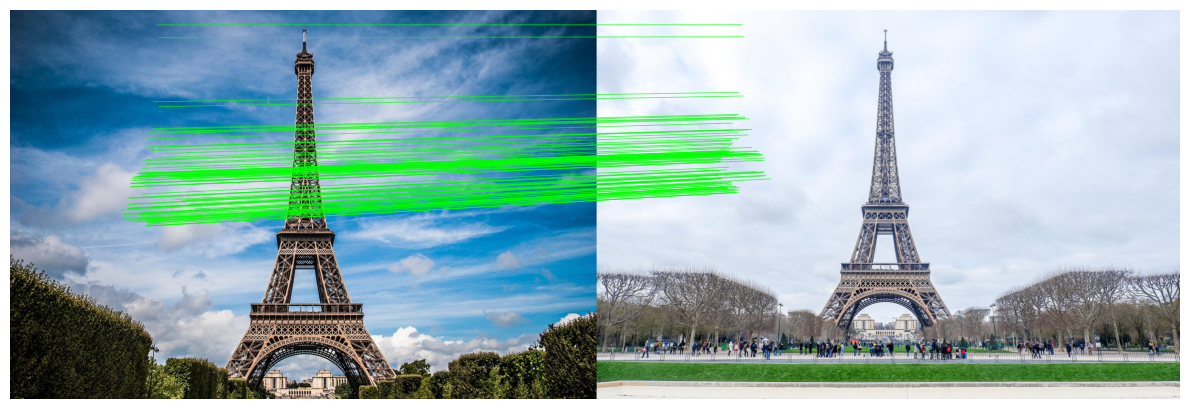

In [15]:
url2 = "https://cdn.pixabay.com/photo/2019/04/05/09/33/the-eiffel-tower-4104637_1280.jpg"
url1 = "https://cdn.pixabay.com/photo/2015/10/06/18/26/eiffel-tower-975004_1280.jpg"


run_inference_from_urls(url1, url2, "/kaggle/working/patch2pix_pretrained.pth")

In [16]:
def visualize_matches(img1, img2, matches, scores, n_show=100, min_score=0.5):
    """Display side-by-side match visualization with better accuracy and clarity"""
    
    # Convert PIL to NumPy if needed
    if isinstance(img1, Image.Image):
        img1 = np.array(img1)
    if isinstance(img2, Image.Image):
        img2 = np.array(img2)
    
    # Make copies to avoid modifying original images
    img1_display = img1.copy()
    img2_display = img2.copy()
    
    # Convert to RGB if grayscale
    if len(img1_display.shape) == 2:
        img1_display = cv2.cvtColor(img1_display, cv2.COLOR_GRAY2RGB)
    if len(img2_display.shape) == 2:
        img2_display = cv2.cvtColor(img2_display, cv2.COLOR_GRAY2RGB)

    # --- Resize both images to same height ---
    h1, w1 = img1_display.shape[:2]
    h2, w2 = img2_display.shape[:2]
    target_h = min(h1, h2)
    
    # Calculate new widths maintaining aspect ratio
    new_w1 = int(w1 * target_h / h1)
    new_w2 = int(w2 * target_h / h2)
    
    # Resize images
    img1_resized = cv2.resize(img1_display, (new_w1, target_h))
    img2_resized = cv2.resize(img2_display, (new_w2, target_h))
    
    # Calculate scale factors for match coordinates
    scale_x1 = new_w1 / w1
    scale_y1 = target_h / h1
    scale_x2 = new_w2 / w2
    scale_y2 = target_h / h2

    # --- Concatenate side-by-side ---
    concat = np.concatenate((img1_resized, img2_resized), axis=1)

    # --- Filter matches by score and select top ones ---
    valid_indices = scores >= min_score
    filtered_matches = matches[valid_indices]
    filtered_scores = scores[valid_indices]
    
    # Pick top matches
    n_show = min(n_show, len(filtered_matches))
    if n_show > 0:
        idx = np.argsort(-filtered_scores)[:n_show]
        top_matches = filtered_matches[idx]
        top_scores = filtered_scores[idx]
    else:
        top_matches = np.array([])
        top_scores = np.array([])

    # --- Create visualization ---
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(concat)
    
    # Define internal offset values (adjust these as needed)
    offset_x = 300  # Example offset in x direction (positive shifts right)
    offset_y = 20  # Example offset in y direction (positive shifts down)
    
    # Plot matches with color coding by score and apply internal offset
    for i, (match, score) in enumerate(zip(top_matches, top_scores)):
        x1, y1, x2, y2 = match
        
        # Scale coordinates to resized image dimensions and apply offset
        x1_scaled = (x1 * scale_x1) + offset_x
        y1_scaled = (y1 * scale_y1) + offset_y
        x2_scaled = (x2 * scale_x2 + new_w1) + offset_x  # Add offset for second image
        y2_scaled = (y2 * scale_y2) + offset_y
        
        # Color based on confidence score (green=high, red=low)
        color = plt.cm.viridis(score)  # or use plt.cm.plasma, plt.cm.inferno
        linewidth = 1.0 + score * 2  # Thicker lines for higher confidence
        
        # Draw match line
        ax.plot([x1_scaled, x2_scaled], [y1_scaled, y2_scaled], 
                color=color, linewidth=linewidth, alpha=0.8)
        
        # Draw keypoints
        ax.scatter(x1_scaled, y1_scaled, c=[color], s=20, alpha=0.9, marker='o')
        ax.scatter(x2_scaled, y2_scaled, c=[color], s=20, alpha=0.9, marker='o')

    ax.set_title(f'Feature Matches ({len(top_matches)} shown, {len(filtered_matches)} total above score {min_score})', 
                 fontsize=14, pad=20)
    ax.axis('off')
    
    # Add colorbar to show score mapping
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                              norm=plt.Normalize(vmin=min(top_scores) if len(top_scores) > 0 else 0, 
                                               vmax=max(top_scores) if len(top_scores) > 0 else 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.01)
    cbar.set_label('Match Confidence Score', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displaying {len(top_matches)} matches (min score: {min_score:.3f})")
    if len(top_scores) > 0:
        print(f"Score range: {top_scores.min():.3f} - {top_scores.max():.3f}")

Fetching image: https://cdn.pixabay.com/photo/2015/10/06/18/26/eiffel-tower-975004_1280.jpg
Fetching image: https://cdn.pixabay.com/photo/2019/04/05/09/33/the-eiffel-tower-4104637_1280.jpg
Initializing Patch2Pix configuration...
Load model: /kaggle/working/patch2pix_pretrained.pth  vals: [inf, 0.0, inf, 0.0]
Initialize Patch2Pix: backbone=ResNet34 cstride=True upsample=8
Init regressor Namespace(conv_dims=[512, 512], conv_kers=[3, 3], conv_strs=[2, 1], fc_dims=[512, 256], psize=[16, 16], feat_comb='pre', shared=False, pshift=8, panc=8, feat_dim=259)
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
Xavier initialize all model parameters
Initialize ResNet using pretrained model from https://download.pytorch.org/models/resnet34-333f7ec4.pth
Reload all model parameters from weights dict
Freezing feature extractor 

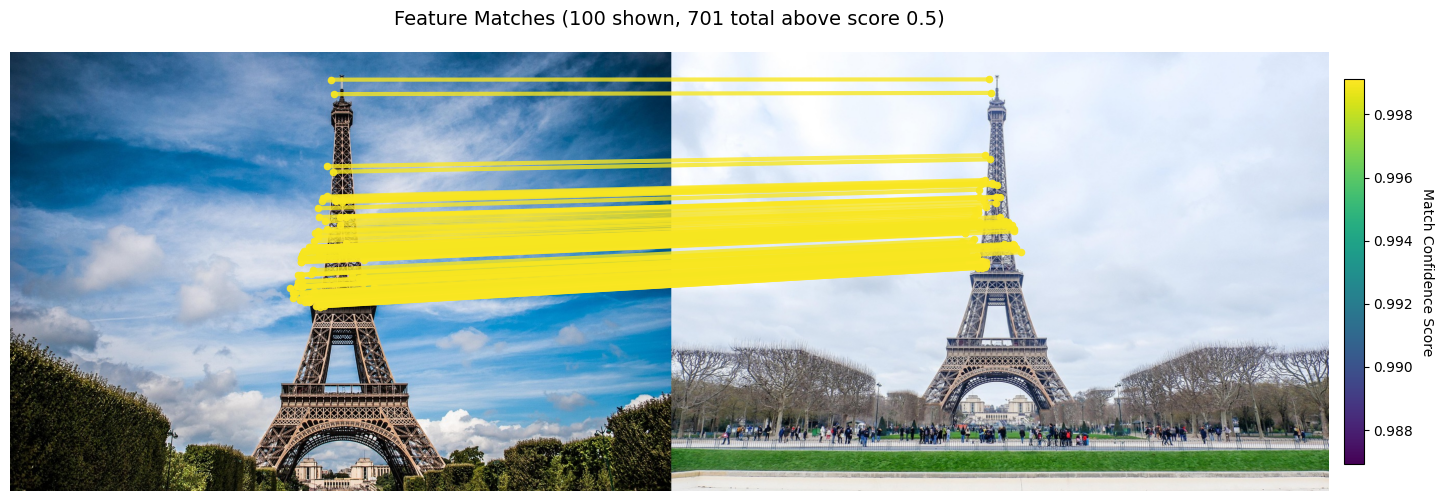

Displaying 100 matches (min score: 0.500)
Score range: 0.987 - 0.999


In [17]:
url2 = "https://cdn.pixabay.com/photo/2019/04/05/09/33/the-eiffel-tower-4104637_1280.jpg"
url1 = "https://cdn.pixabay.com/photo/2015/10/06/18/26/eiffel-tower-975004_1280.jpg"


run_inference_from_urls(url1, url2, "/kaggle/working/patch2pix_pretrained.pth")

Fetching image: https://cdn.pixabay.com/photo/2019/11/07/11/27/taj-mahal-4608641_1280.jpg
Fetching image: https://cdn.pixabay.com/photo/2019/03/12/20/19/india-4051753_1280.jpg
Initializing Patch2Pix configuration...
Load model: /kaggle/working/patch2pix_pretrained.pth  vals: [inf, 0.0, inf, 0.0]
Initialize Patch2Pix: backbone=ResNet34 cstride=True upsample=8
Init regressor Namespace(conv_dims=[512, 512], conv_kers=[3, 3], conv_strs=[2, 1], fc_dims=[512, 256], psize=[16, 16], feat_comb='pre', shared=False, pshift=8, panc=8, feat_dim=259)
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
FeatRegressNet:  feat_comb:pre psize:16 out:5 feat_dim:518 conv_kers:[3, 3] conv_dims:[512, 512] conv_str:[2, 1] 
Xavier initialize all model parameters
Initialize ResNet using pretrained model from https://download.pytorch.org/models/resnet34-333f7ec4.pth
Reload all model parameters from weights dict
Freezing feature extractor params upto l

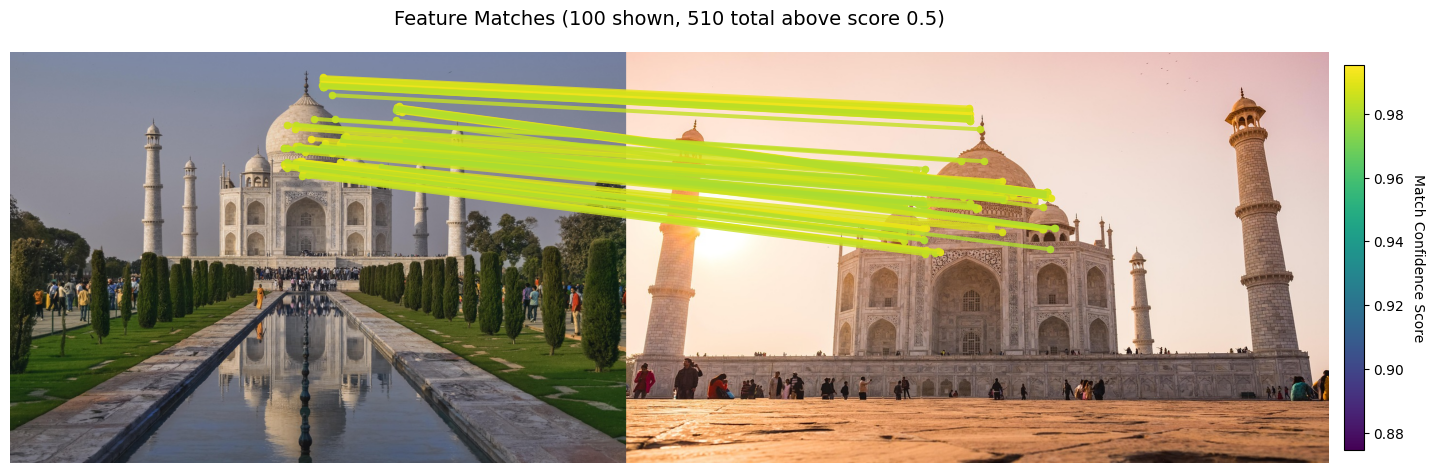

Displaying 100 matches (min score: 0.500)
Score range: 0.874 - 0.995


In [18]:
url2 = "https://cdn.pixabay.com/photo/2019/03/12/20/19/india-4051753_1280.jpg"
url1 = "https://cdn.pixabay.com/photo/2019/11/07/11/27/taj-mahal-4608641_1280.jpg"


run_inference_from_urls(url1, url2, "/kaggle/working/patch2pix_pretrained.pth")